In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import rasterio
import matplotlib
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

from maskrcnn.preprocess.sample_aoi import load_df
from maskrcnn.postprocess.validate import transform_coord, plot_scatter


matplotlib.rc('pdf', fonttype=42)

In [2]:
# input path
# image index data
IDX_IN_DIR = 'data/Mexico/Meta/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Mexico/Meta/aoi_download_log.csv'
# census data
CEN_IN_DIR = 'data/Mexico/Meta/census.csv'
# satellite data
NL_IN_DIR = 'data/External/Nightlight/VIIRS_DNB_MX_2019.tif'
SAT_IN_DIR = 'data/Mexico/Merged/sat.csv'

# output path
OUT_DIR = 'output/fig-mx'

SAMPLE_NAME = '2019Oct9'

In [3]:
# LOAD IMAGE META DATA
# read image index data frame
df_idx = pd.merge(
    pd.read_csv(IDX_IN_DIR), pd.read_csv(LOG_IN_DIR),
    how='outer', on='index')
df_idx = df_idx.loc[:, [
    'index', 'ent', 'mun', 'loc', 'chip', 'status',
    'lon_min', 'lon_max', 'lat_min', 'lat_max']]

In [4]:
# LOAD CENSUS DATA
# read census data
df_cen = pd.read_csv(CEN_IN_DIR)

# select sample
df_cen = df_cen.loc[df_cen['sample'] == SAMPLE_NAME, :]

# drop NA localities with no images
df_cen = pd.merge(
    df_cen,
    df_idx.groupby(['ent', 'mun', 'loc']).agg(
        no_missing=pd.NamedAgg(
            column='status', aggfunc=lambda x: sum(pd.isna(x)))),
    how='outer',
    on=['ent', 'mun', 'loc'])
df_cen = df_cen.loc[df_cen['no_missing'] == 0, :]

# calculate PCA scores
db_cols = ['VPH_RADIO', 'VPH_TV', 'VPH_REFRI', 'VPH_LAVAD',
           'VPH_AUTOM', 'VPH_PC', 'VPH_TELEF', 'VPH_CEL', 'VPH_INTER']
housing_cols = ['VPH_PISODT', 'VPH_2YMASD', 'VPH_3YMASC']
public_cols = ['VPH_C_ELEC', 'VPH_AGUADV', 'VPH_EXCSA', 'VPH_DRENAJ']
vph_cols = db_cols + housing_cols + public_cols  # all

for cols, output_col in zip(
        [db_cols, housing_cols, public_cols, vph_cols],
        ['cen_durable_score_pca', 'cen_housing_score_pca',
         'cen_public_score_pca', 'cen_asset_score_pca']):
    # demean
    centered = (df_cen.loc[:, cols].values -
                df_cen.loc[:, cols].values.mean(axis=0)[np.newaxis, :])
    m = PCA(n_components=1)
    df_cen.loc[:, output_col] = m.fit_transform(centered)

df_cen['cen_housing_score_pca'] *= -1
df_cen['cen_public_score_pca'] *= -1

# renamed columns in census, translate to English
CEN_COLS = {
    'POBTOT': 'cen_pop',
    'VIVTOT': 'cen_house',
    'TVIVHAB': 'cen_inhab',
    # 'VPH_SNBIEN': 'cen_nodurable',
    # 'VPH_1CUART': 'cen_1room',
    # 'VPH_3YMASC': 'cen_3plusroom',
    # 'VPH_REFRI': 'cen_refri',
    # 'VPH_AUTOM': 'cen_autom',
    # 'VPH_C_ELEC': 'cen_elec',
    # 'VPH_PISODT': 'cen_floor',
    # 'VPH_AGUADV': 'cen_water',
    # 'VPH_EXCSA': 'cen_toilet',
    # 'VPH_DRENAJ': 'cen_drainage',
    # 'VPH_INTER': 'cen_internet',
}

# rename columns
df_cen = df_cen.rename(columns=CEN_COLS)

In [5]:
# LOAD SATELLITE
# read satellite predictions
df_sat = pd.read_csv(SAT_IN_DIR)
# link to locality identifier
df_sat = pd.merge(df_sat, df_idx, how='left', on='index')
# create new var
df_sat.loc[:, 'RGB_mean'] = df_sat.loc[:, ['R_mean', 'G_mean', 'B_mean']].mean(axis=1)

# grouping into localities
df_sat = df_sat.groupby(['ent', 'mun', 'loc']).agg(
    sat_house=pd.NamedAgg(column='area', aggfunc='count'),
    sat_size_mean=pd.NamedAgg(column='area', aggfunc=np.nanmean),
    sat_size_sum=pd.NamedAgg(column='area', aggfunc=np.nansum),
    sat_lum_mean=pd.NamedAgg(column='RGB_mean', aggfunc=np.nanmean),
)
df_sat.loc[:, 'sat_house'] = df_sat['sat_house'].fillna(0)
df_sat.loc[:, 'sat_size_sum'] = df_sat['sat_size_sum'].fillna(0)

# scale areas / distances
df_sat[['sat_size_mean', 'sat_size_sum']] *= (
    ((0.001716 * 111000 / 800) ** 2) * np.cos(23 / 180 * np.pi))  # in sq meters

In [6]:
# merge satellite and census
df = pd.merge(
    df_sat,
    df_cen,
    how='right', on=['ent', 'mun', 'loc'])

# compute per capita values
df.loc[:, 'sat_size_sum_pc'] = df['sat_size_sum'] / df['cen_pop']

# extract nightlight values
ds = rasterio.open(NL_IN_DIR)
band = ds.read().squeeze(0)

idx = np.round(transform_coord(
    transform=ds.transform,
    to='colrow',
    xy=df.loc[:, ['lon', 'lat']].values)).astype(np.int)

df.loc[:, 'sat_nightlight'] = [band[i[1], i[0]] for i in idx]

In [7]:
# not winsorized yet

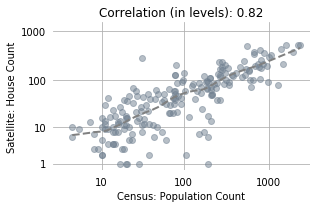

In [8]:
plot_scatter(
    col_x_key='cen_pop',
    col_x_label='Census: Population Count',
    transform_x=lambda x: np.log10(x + 1),
    xlim=(np.log10(2 + 1), np.log10(3000 + 1)),
    xticks=[np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    xticklabels=[10, 100, 1000],
    col_y_key='sat_house',
    col_y_label='Satellite: House Count',
    transform_y=lambda x: np.log10(x + 1),
    ylim=(np.log10(0.5 + 1), np.log10(1500 + 1)),
    yticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    yticklabels=[1, 10, 100, 1000],
    line=True, df=df, out_dir=OUT_DIR, show=True)

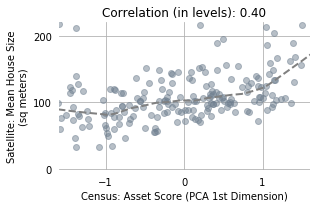

In [9]:
plot_scatter(
    col_x_key='cen_asset_score_pca',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    xlim=(-1.6, 1.6),
    xticks=[-1, 0, 1],
    col_y_key='sat_size_mean',
    col_y_label='Satellite: Mean House Size\n(sq meters)',
    ylim=(-1, 220),
    yticks=[0, 100, 200],
    line=True, df=df, out_dir=OUT_DIR, show=True)

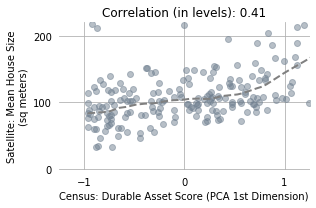

In [10]:
plot_scatter(
    col_x_key='cen_durable_score_pca',
    col_x_label='Census: Durable Asset Score (PCA 1st Dimension)',
    xlim=(-1.25, 1.25),
    xticks=[-1, 0, 1],
    col_y_key='sat_size_mean',
    col_y_label='Satellite: Mean House Size\n(sq meters)',
    ylim=(-1, 220),
    yticks=[0, 100, 200],
    line=True, df=df, out_dir=OUT_DIR, show=True)

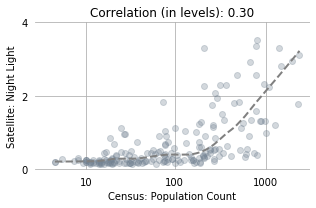

In [11]:
plot_scatter(
    col_x_key='cen_pop',
    col_x_label='Census: Population Count',
    transform_x=lambda x: np.log10(x + 1),
    xlim=(np.log10(3), np.log10(3000)),
    xticks=[np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    xticklabels=[10, 100, 1000],
    col_y_key='sat_nightlight',
    col_y_label='Satellite: Night Light',
    ylim=(-0.01, 4),
    yticks=[0, 2, 4],
    alpha=0.3, line=True, df=df,
    out_dir=OUT_DIR,
    show=True)

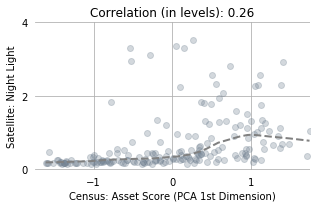

In [12]:
plot_scatter(
    col_x_key='cen_asset_score_pca',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    xlim=(-1.75, 1.75),
    xticks=[-1, 0, 1],
    col_y_key='sat_nightlight',
    col_y_label='Satellite: Night Light',
    ylim=(-0.01, 4),
    yticks=[0, 2, 4],
    alpha=0.3,
    line=True, df=df, out_dir=OUT_DIR, show=True)

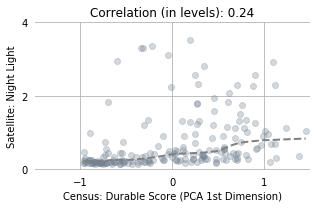

In [13]:
plot_scatter(
    col_x_key='cen_durable_score_pca',
    col_x_label='Census: Durable Score (PCA 1st Dimension)',
    xlim=(-1.5, 1.5),
    xticks=[-1, 0, 1],
    col_y_key='sat_nightlight',
    col_y_label='Satellite: Night Light',
    ylim=(-0.01, 4),
    yticks=[0, 2, 4],
    alpha=0.3,
    line=True, df=df, out_dir=OUT_DIR, show=True)

In [14]:
sat_cols = [col for col in df.columns if col.startswith('sat')]
cen_cols = [col for col in df.columns if col.startswith('cen')]

for f in glob.glob(os.path.join(OUT_DIR, 'all/*.pdf')):
    os.remove(f)
# massive plotting begins
for sat_col in sat_cols:
    for cen_col in cen_cols:
        plot_scatter(col_x_key=cen_col, col_y_key=sat_col,
                     col_x_label=cen_col, col_y_label=sat_col,
                     df=df, out_dir=os.path.join(OUT_DIR, 'all'))